In [43]:
import pandas as pd
import matplotlib.pyplot as plt

Based on : https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Incorporating_Related_Time_Series_dataset_to_your_Predictor/Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb

Data files available here : https://www.kaggle.com/code/milanzdravkovic/pharma-sales-data-analysis-and-forecasting/data

In [96]:
hourly_raw=pd.read_csv('data/saleshourly.csv')
daily_raw=pd.read_csv('data/salesdaily.csv')

In [98]:
hourly_raw.head

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [99]:
daily_raw.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [46]:
import boto3
import sagemaker

region = boto3.Session("s3").region_name
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast')
forecastquery = session.client(service_name='forecastquery')
account_id = boto3.client('sts').get_caller_identity().get('Account')

assert forecast.list_predictors()
sagemaker_session = sagemaker.session.Session()
bucket_name = sagemaker_session.default_bucket()
key='chapter10/data'


In [47]:
import json
from tqdm.auto import trange
def get_or_create_iam_role( role_name ):

    iam = boto3.client("iam")

    assume_role_policy_document = {
        "Version": "2012-10-17",
        "Statement": [
            {
              "Effect": "Allow",
              "Principal": {
                "Service": "forecast.amazonaws.com"
              },
              "Action": "sts:AssumeRole"
            }
        ]
    }

    try:
        create_role_response = iam.create_role(
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
        )
        role_arn = create_role_response["Role"]["Arn"]
        print("Created", role_arn)
        
        print("Attaching policies...")
        iam.attach_role_policy(
            RoleName = role_name,
            PolicyArn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
        )

        iam.attach_role_policy(
            RoleName=role_name,
            PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
        )

        print("Waiting for a minute to allow IAM role policy attachment to propagate")
        for i in trange(60):
            time.sleep(1.0)
            
    except iam.exceptions.EntityAlreadyExistsException:
        print("The role " + role_name + " already exists, skipping creation")
        role_arn = boto3.resource('iam').Role(role_name).arn

    print("Done.")
    return role_arn

In [48]:
role_arn = get_or_create_iam_role( role_name = 'ForecastNotebookRole-Basic' )
role_arn

The role ForecastNotebookRole-Basic already exists, skipping creation
Done.


'arn:aws:iam::485822383573:role/ForecastNotebookRole-Basic'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


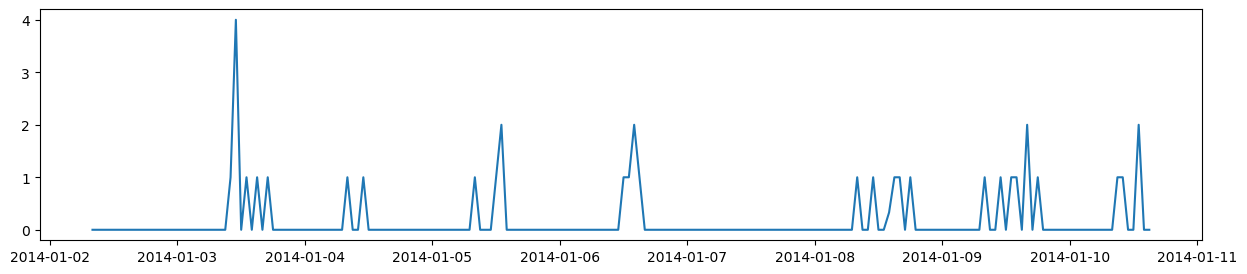

In [49]:
hourly_raw['datum'] = pd.to_datetime(hourly_raw["datum"])
target_df=hourly_raw[['datum','M01AB']]
target_df['item_id'] = "M01AB"

target_df.head()

target_df.to_csv('data/target_df.csv', index=False)
plt.figure(figsize=(15, 3))
plt.plot(target_df['datum'][:200], target_df['M01AB'][:200])
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


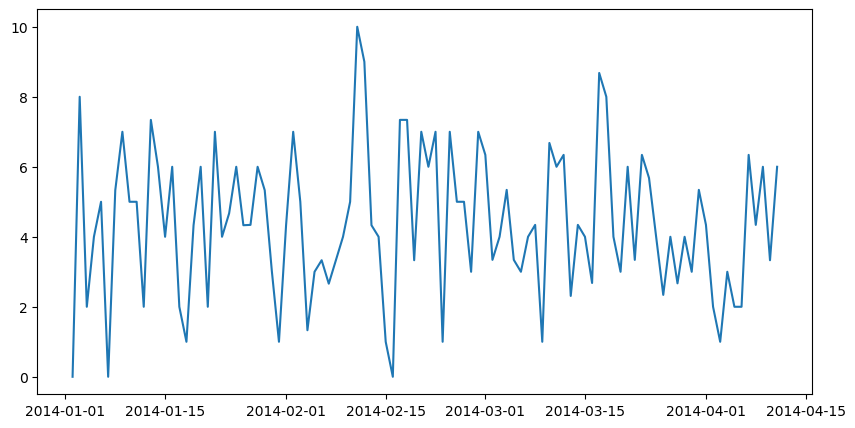

In [50]:
daily_raw['datum'] = pd.to_datetime(daily_raw["datum"])
target_df_daily=daily_raw[['datum','M01AB']]
target_df_daily['item_id'] = "M01AB"

target_df_daily.head()

target_df_daily.to_csv('data/target_df_daily.csv', index=False)
plt.figure(figsize=(10, 5))
plt.plot(target_df_daily['datum'][:100], target_df_daily['M01AB'][:100])
plt.show()

In [51]:
s3 = boto3.Session().resource('s3')
s3.Bucket(bucket_name).Object(key+'/target_df.csv').upload_file('data/target_df.csv')
ts_s3_path = f"s3://{bucket_name}/{key}/target_df.csv"

print(f"\nDone, the dataset is uploaded to S3 at {ts_s3_path}.")


Done, the dataset is uploaded to S3 at s3://sagemaker-us-east-1-485822383573/chapter10/data/target_df.csv.


In [52]:
s3.Bucket(bucket_name).Object(key+'/target_df_daily.csv').upload_file('data/target_df_daily.csv')
ts_s3_path_daily = f"s3://{bucket_name}/{key}/target_df_daily.csv"

print(f"\nDone, the dataset is uploaded to S3 at {ts_s3_path_daily}.")


Done, the dataset is uploaded to S3 at s3://sagemaker-us-east-1-485822383573/chapter10/data/target_df_daily.csv.


In [60]:
dataset_group_name = "pharma_sales"
dataset_arns = []
try:
    create_dataset_group_response = \
        forecast.create_dataset_group(Domain="CUSTOM",
                                      DatasetGroupName=dataset_group_name,
                                      DatasetArns=dataset_arns)
    dataset_group_arn = create_dataset_group_response['DatasetGroupArn']
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name, dataset_group_arn))
except:
    dataset_group_arn='arn:aws:forecast:{}:{}:dataset-group/{}'.format(region, account_id, dataset_group_name)
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name, response['DatasetGroupArn']))
    

Dataset group pharma_sales created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset-group/pharma_sales


In [71]:
dataset_group_name_daily = "pharma_sales_daily"
dataset_arns_daily = []

try:
    create_dataset_group_response = \
        forecast.create_dataset_group(Domain="CUSTOM",
                                      DatasetGroupName=dataset_group_name_daily,
                                      DatasetArns=dataset_arns_daily)
    dataset_group_arn_daily = create_dataset_group_response['DatasetGroupArn']
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name_daily, dataset_group_arn))

except:   
    dataset_group_arn_daily='arn:aws:forecast:{}:{}:dataset-group/{}'.format(region, account_id, dataset_group_name_daily)
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn_daily)
    print('Dataset group {} created with ARN: {}'.format(dataset_group_name_daily, response['DatasetGroupArn']))
    

Dataset group pharma_sales_daily created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset-group/pharma_sales_daily


In [72]:
TS_SCHEMA = {
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

In [73]:
DATASET_FREQUENCY = "H" # H for hourly.
TS_DATASET_NAME = dataset_group_name+"_MOIAB"
try:
    create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                      DatasetType='TARGET_TIME_SERIES',
                                                      DatasetName=TS_DATASET_NAME,
                                                      DataFrequency=DATASET_FREQUENCY,
                                                      Schema=TS_SCHEMA)

    ts_dataset_arn = create_dataset_response['DatasetArn']
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME, ts_dataset_arn))
except:
    ts_dataset_arn='arn:aws:forecast:{}:{}:dataset/{}'.format(region, account_id, TS_DATASET_NAME)
    response=describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn)
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME, response['DatasetArn']))

Dataset pharma_sales_MOIAB created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB


In [74]:
DATASET_FREQUENCY_D = "D"
TS_DATASET_NAME_DAILY = dataset_group_name+"_MOIAB_DAILY"

try:
    create_dataset_response = forecast.create_dataset(Domain="CUSTOM",
                                                      DatasetType='TARGET_TIME_SERIES',
                                                      DatasetName=TS_DATASET_NAME_DAILY,
                                                      DataFrequency=DATASET_FREQUENCY_D,
                                                      Schema=TS_SCHEMA)

    ts_dataset_arn_daily = create_dataset_response['DatasetArn']
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME_DAILY, ts_dataset_arn_daily))
except:
    ts_dataset_arn_daily='arn:aws:forecast:{}:{}:dataset/{}'.format(region, account_id, TS_DATASET_NAME_DAILY)
    response=describe_dataset_response = forecast.describe_dataset(DatasetArn=ts_dataset_arn_daily)
    print('Dataset {} created with ARN: {}'.format(TS_DATASET_NAME_DAILY, response['DatasetArn']))

Dataset pharma_sales_MOIAB_DAILY created with ARN: arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB_DAILY


In [75]:
dataset_arns=[]
dataset_arns.append(ts_dataset_arn)
print(dataset_arns)
try:
    response=forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)
    print(response)
except:
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)
    print(response)

['arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB']
{'ResponseMetadata': {'RequestId': '56723ec4-5bd7-45d7-b381-ebcfe71c07dc', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 31 Aug 2022 00:21:55 GMT', 'x-amzn-requestid': '56723ec4-5bd7-45d7-b381-ebcfe71c07dc', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [76]:
dataset_arns=[]
dataset_arns.append(ts_dataset_arn_daily)
print(dataset_arns)
try:
    response=forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn_daily, DatasetArns=dataset_arns)
    print(response)
except:
    response=forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn_daily)
    print(response)

['arn:aws:forecast:us-east-1:485822383573:dataset/pharma_sales_MOIAB_DAILY']
{'ResponseMetadata': {'RequestId': '37db837e-d6d3-4612-9181-11806cf9a689', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 31 Aug 2022 00:22:22 GMT', 'x-amzn-requestid': '37db837e-d6d3-4612-9181-11806cf9a689', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [77]:
import time
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"
TS_IMPORT_JOB_NAME = "HOURLY_IMPORT"
TIMEZONE = "EST"

try:

    ts_dataset_import_job_response = \
        forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME,
                                           DatasetArn=ts_dataset_arn,
                                           DataSource= {
                                             "S3Config" : {
                                                 "Path": ts_s3_path,
                                                 "RoleArn": role_arn
                                             } 
                                           },
                                           TimestampFormat=TIMESTAMP_FORMAT,
                                           TimeZone = TIMEZONE)

    ts_dataset_import_job_arn = ts_dataset_import_job_response['DatasetImportJobArn']
    describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
    print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn} to become ACTIVE. This process could take 5-10 minutes.\n\nCurrent Status:")

    while True:
        status=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    ts_dataset_import_job_arn='arn:aws:forecast:{}:{}:dataset-import-job/{}/{}'.format(region, account_id, TS_DATASET_NAME,TS_IMPORT_JOB_NAME)
    response=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn)
    print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn} is now {response['Status']}.")



The Dataset Import Job with ARN arn:aws:forecast:us-east-1:485822383573:dataset-import-job/pharma_sales_MOIAB/HOURLY_IMPORT is now ACTIVE.


In [78]:
import time
TIMESTAMP_FORMAT_DAILY = "yyyy-MM-dd"
TS_IMPORT_JOB_NAME_DAILY = "DAILY_IMPORT"
TIMEZONE = "EST"

try:

    ts_dataset_import_job_response = \
        forecast.create_dataset_import_job(DatasetImportJobName=TS_IMPORT_JOB_NAME_DAILY,
                                           DatasetArn=ts_dataset_arn_daily,
                                           DataSource= {
                                             "S3Config" : {
                                                 "Path": ts_s3_path_daily,
                                                 "RoleArn": role_arn
                                             } 
                                           },
                                           TimestampFormat=TIMESTAMP_FORMAT_DAILY,
                                           TimeZone = TIMEZONE)

    ts_dataset_import_job_arn_daily = ts_dataset_import_job_response['DatasetImportJobArn']
    describe_dataset_import_job_response = forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn_daily)
    print(f"Waiting for Dataset Import Job with ARN {ts_dataset_import_job_arn_daily} to become ACTIVE. This process could take 5-10 minutes.\n\nCurrent Status:")

    while True:
        status=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn_daily)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    ts_dataset_import_job_arn_daily='arn:aws:forecast:{}:{}:dataset-import-job/{}/{}'.format(region, account_id, TS_DATASET_NAME_DAILY,TS_IMPORT_JOB_NAME_DAILY)
    response=forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn_daily)
    print(f"\n\nThe Dataset Import Job with ARN {ts_dataset_import_job_arn_daily} is now {response['Status']}.")



The Dataset Import Job with ARN arn:aws:forecast:us-east-1:485822383573:dataset-import-job/pharma_sales_MOIAB_DAILY/DAILY_IMPORT is now ACTIVE.


In [79]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{TS_DATASET_NAME}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = pharma_sales_MOIAB_deep_ar_plus


In [80]:
FORECAST_LENGTH = 24

try:
    create_predictor_response = \
        forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                  ForecastHorizon=FORECAST_LENGTH,
                                  PerformAutoML=False,
                                  PerformHPO=False,
                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                  FeaturizationConfig= {"ForecastFrequency": 'H'}
                                 )
    predictor_arn_deep_ar = create_predictor_response['PredictorArn']
    print(f"Waiting for predictor with ARN {predictor_arn_deep_ar} to become ACTIVE. This process could take 20-30 minutes.\n\nCurrent Status:")
    while True:
        status=forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
    print(f"Predictor with ARN {predictor_arn_deep_ar} :{status}")
except:
    predictor_arn_deep_ar='arn:aws:forecast:{}:{}:predictor/{}'.format(region, account_id, predictor_name_deep_ar)
    status=forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)['Status']
    print(f"Predictor with ARN {predictor_arn_deep_ar}: {status}")
    

Predictor with ARN arn:aws:forecast:us-east-1:485822383573:predictor/pharma_sales_MOIAB_deep_ar_plus: ACTIVE


In [81]:
algorithm_daily = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm_daily
predictor_name_prophet = f"{TS_DATASET_NAME_DAILY}_{algorithm_daily.lower()}"
print(f"Predictor Name = {predictor_name_prophet}")

Predictor Name = pharma_sales_MOIAB_DAILY_prophet


In [82]:
FORECAST_LENGTH = 10

try:
    create_predictor_response = \
        forecast.create_predictor(PredictorName=predictor_name_prophet,
                                  AlgorithmArn=algorithm_arn_prophet,
                                  ForecastHorizon=FORECAST_LENGTH,
                                  PerformAutoML=False,
                                  PerformHPO=False,
                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn_daily},
                                  FeaturizationConfig= {"ForecastFrequency": 'D'}
                                 )
    predictor_arn_prophet = create_predictor_response['PredictorArn']
    print(f"Waiting for predictor with ARN {predictor_arn_prophet} to become ACTIVE. This process could take 20-30 minutes.\n\nCurrent Status:")
    while True:
        status=forecast.describe_predictor(PredictorArn=predictor_arn_prophet)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    predictor_arn_prophet='arn:aws:forecast:{}:{}:predictor/{}'.format(region, account_id, predictor_name_prophet)
    status=forecast.describe_predictor(PredictorArn=predictor_arn_prophet)['Status']
    print(f"Predictor with ARN {predictor_arn_prophet}: {status}")
    

Predictor with ARN arn:aws:forecast:us-east-1:485822383573:predictor/pharma_sales_MOIAB_DAILY_prophet: ACTIVE


In [83]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 0.06799650728058045,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 2.0969126952121213},
       {'Quantile': 0.5, 'LossValue': 1.1322591406060607},
       {'Quantile': 0.1, 'LossValue': 0.47394512951515155}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 1.3516351381818186,
        'RMSE': 0.06799650728058045,
        'MASE': 0.6476585037121213,
        'MAPE': 0.041576848169191924}],
      'AverageWeightedQuantileLoss': 1.2343723217777778}},
    {'TestWindowStart': datetime.datetime(2019, 10, 7, 20, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 10, 8, 20, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 0.06799650728058045,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 2.096912

In [84]:
error_metrics_deep_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_deep_prophet

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 3.153945722472903,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.26808240230829533},
       {'Quantile': 0.5, 'LossValue': 0.5510308508287483},
       {'Quantile': 0.1, 'LossValue': 0.1956379955444281}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.5290025393847725,
        'RMSE': 3.153945722472903,
        'MASE': 0.7080495527150034,
        'MAPE': 1.9635671560299386}],
      'AverageWeightedQuantileLoss': 0.3382504162271572}},
    {'TestWindowStart': datetime.datetime(2019, 9, 29, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2019, 10, 9, 0, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 3.153945722472903,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.26808240230829533},
 

In [85]:
forecast_name_deep_ar = f"{TS_DATASET_NAME}_deeparp"
print(f"Forecast Name = {forecast_name_deep_ar}")

Forecast Name = pharma_sales_MOIAB_deeparp


In [86]:
try:
    create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                            PredictorArn=predictor_arn_deep_ar)
    forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']
    print('creating forecast...')
    while True:
        status=forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
    print('Forecast {}: {}'.format(forecast_arn_deep_ar, status))
except:
    forecast_arn_deep_ar='arn:aws:forecast:{}:{}:forecast/{}'.format(region, account_id, forecast_name_deep_ar)
    status=forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)['Status']
    print('Forecast {}: {}'.format(forecast_arn_deep_ar, status))
    
    

Forecast arn:aws:forecast:us-east-1:485822383573:forecast/pharma_sales_MOIAB_deeparp: ACTIVE


In [87]:
forecast_response_deep = forecastquery.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": 'M01AB'})
forecast_response_deep

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2019-10-08T20:00:00',
     'Value': -0.0212139282},
    {'Timestamp': '2019-10-08T21:00:00', 'Value': -0.023361275},
    {'Timestamp': '2019-10-08T22:00:00', 'Value': -0.0044957907},
    {'Timestamp': '2019-10-08T23:00:00', 'Value': -0.0029490117},
    {'Timestamp': '2019-10-09T00:00:00', 'Value': -0.0014466448},
    {'Timestamp': '2019-10-09T01:00:00', 'Value': -0.0008959283},
    {'Timestamp': '2019-10-09T02:00:00', 'Value': -0.0005988376},
    {'Timestamp': '2019-10-09T03:00:00', 'Value': -0.0009790345},
    {'Timestamp': '2019-10-09T04:00:00', 'Value': -0.0011201639},
    {'Timestamp': '2019-10-09T05:00:00', 'Value': -0.0009358527},
    {'Timestamp': '2019-10-09T06:00:00', 'Value': -0.0010048471},
    {'Timestamp': '2019-10-09T07:00:00', 'Value': -0.0019908166},
    {'Timestamp': '2019-10-09T08:00:00', 'Value': -0.0163108818},
    {'Timestamp': '2019-10-09T09:00:00', 'Value': -0.0297796},
    {'Timestamp': '2019-10-09T10:00:00', 

In [88]:
forecast_name_prophet = f"{TS_DATASET_NAME_DAILY}_prophetp"
print(f"Forecast Name = {forecast_name_prophet}")

Forecast Name = pharma_sales_MOIAB_DAILY_prophetp


In [89]:
try:
    create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                            PredictorArn=predictor_arn_prophet)
    forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']
    print('creating forecast...')
    while True:
        status=forecast.describe_forecast(ForecastArn=forecast_arn_prophet)['Status']
        print(status)
        if status in ('ACTIVE', 'CREATE_FAILED'): break
        time.sleep(10)
except:
    forecast_arn_prophet='arn:aws:forecast:{}:{}:forecast/{}'.format(region, account_id, forecast_name_prophet)
    status=forecast.describe_forecast(ForecastArn=forecast_arn_prophet)['Status']
    print('Forecast {}: {}'.format(forecast_arn_prophet, status))

Forecast arn:aws:forecast:us-east-1:485822383573:forecast/pharma_sales_MOIAB_DAILY_prophetp: ACTIVE


In [90]:
forecast_response_prophet = forecastquery.query_forecast(
    ForecastArn=forecast_arn_prophet,
    Filters={"item_id": 'M01AB'})
forecast_response_prophet

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2019-10-09T00:00:00',
     'Value': 1.3382125412600696},
    {'Timestamp': '2019-10-10T00:00:00', 'Value': 1.8837877421191611},
    {'Timestamp': '2019-10-11T00:00:00', 'Value': 1.777975049643957},
    {'Timestamp': '2019-10-12T00:00:00', 'Value': 1.8768830514973},
    {'Timestamp': '2019-10-13T00:00:00', 'Value': 1.9206473020592258},
    {'Timestamp': '2019-10-14T00:00:00', 'Value': 2.0542500872614182},
    {'Timestamp': '2019-10-15T00:00:00', 'Value': 1.3094920806145498},
    {'Timestamp': '2019-10-16T00:00:00', 'Value': 0.9727950537685568},
    {'Timestamp': '2019-10-17T00:00:00', 'Value': 1.8529310731994326},
    {'Timestamp': '2019-10-18T00:00:00', 'Value': 0.8195599891924861}],
   'p50': [{'Timestamp': '2019-10-09T00:00:00', 'Value': 4.863602685032175},
    {'Timestamp': '2019-10-10T00:00:00', 'Value': 4.742595958515514},
    {'Timestamp': '2019-10-11T00:00:00', 'Value': 4.975498119419591},
    {'Timestamp': '2019-10-12T00:00:0

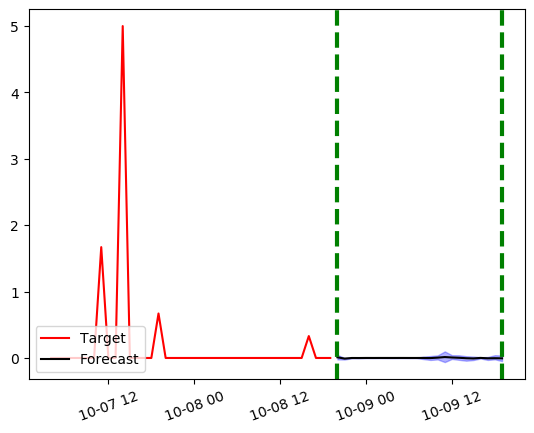

In [93]:
p10 = pd.DataFrame(forecast_response_deep['Forecast']['Predictions']['p10'])
p50 = pd.DataFrame(forecast_response_deep['Forecast']['Predictions']['p50'])
p90 = pd.DataFrame(forecast_response_deep['Forecast']['Predictions']['p90'])
pred_int = p50['Timestamp'].apply(lambda x: pd.Timestamp(x))
fcst_start_date = pred_int.iloc[0]
fcst_end_date = pred_int.iloc[-1]
time_int = target_df['datum'].apply(lambda x: pd.Timestamp(x))
plt.plot(time_int[-40:],target_df['M01AB'].values[-40:], color = 'r')
plt.plot(pred_int, p50['Value'].values, color = 'k')
plt.fill_between(pred_int, 
                 p10['Value'].values,
                 p90['Value'].values,
                 color='b', alpha=0.3);
plt.axvline(x=pd.Timestamp(fcst_start_date), linewidth=3, color='g', ls='dashed')
plt.axvline(x=pd.Timestamp(fcst_end_date), linewidth=3, color='g', ls='dashed')
plt.xticks(rotation=20)
plt.legend(['Target', 'Forecast'], loc = 'lower left')
plt.show()

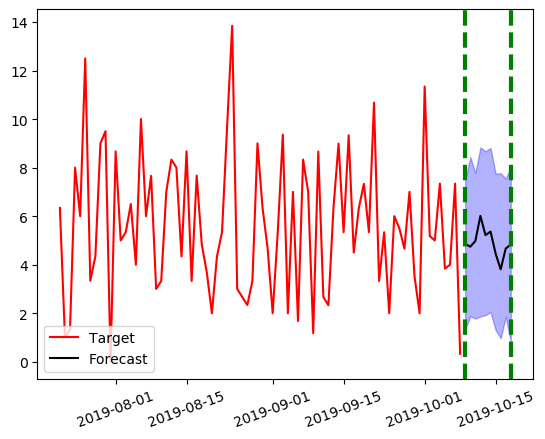

In [95]:
p10 = pd.DataFrame(forecast_response_prophet['Forecast']['Predictions']['p10'])
p50 = pd.DataFrame(forecast_response_prophet['Forecast']['Predictions']['p50'])
p90 = pd.DataFrame(forecast_response_prophet['Forecast']['Predictions']['p90'])
pred_int = p50['Timestamp'].apply(lambda x: pd.Timestamp(x))
fcst_start_date = pred_int.iloc[0]
fcst_end_date = pred_int.iloc[-1]
time_int = target_df_daily['datum'].apply(lambda x: pd.Timestamp(x))
plt.plot(time_int[-80:],target_df_daily['M01AB'].values[-80:], color = 'r')
plt.plot(pred_int, p50['Value'].values, color = 'k')
plt.fill_between(pred_int, 
                 p10['Value'].values,
                 p90['Value'].values,
                 color='b', alpha=0.3);
plt.axvline(x=pd.Timestamp(fcst_start_date), linewidth=3, color='g', ls='dashed')
plt.axvline(x=pd.Timestamp(fcst_end_date), linewidth=3, color='g', ls='dashed')
plt.xticks(rotation=20)
plt.legend(['Target', 'Forecast'], loc = 'lower left')
plt.show()